<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Heshani/Research_IT22570758(unsupervisedlerning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, glob, pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
IMG_SIZE = 128
MAX_RBC_PER_IMAGE = 25
NUM_CLUSTERS = 3  # You can adjust
DATA_FOLDER = "/content/drive/MyDrive/thalassemiaunsupervised/affected"  # folder with all RBC images
SAVE_DIR = "/content/drive/MyDrive/thalassemiaunsupervised"  # save everything here
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
def load_rbc_images(folder):
    images = []
    for p in glob.glob(os.path.join(folder, "*")):
        img = cv2.imread(p)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
    return np.array(images)

X_all = load_rbc_images(DATA_FOLDER)
print("Total RBCs loaded:", len(X_all))

# ========================
# Step 2 - Build CNN feature extractor (ResNet50)
# ========================
img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=img_input)
features = layers.GlobalAveragePooling2D()(base_model.output)
cnn_model = models.Model(inputs=img_input, outputs=features)
print("CNN feature extractor ready.")

# ========================
# Step 3 - Extract CNN features
# ========================
X_preprocessed = preprocess_input(X_all)
features_all = cnn_model.predict(X_preprocessed, verbose=0)
print("Features shape:", features_all.shape)

# ========================
# Step 4 - PCA for dimensionality reduction
# ========================
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features_all)
print("PCA features shape:", features_pca.shape)

# ========================
# Step 5 - KMeans clustering
# ========================
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
clusters = kmeans.fit_predict(features_pca)
print("Cluster counts:", np.bincount(clusters))


Total RBCs loaded: 82
CNN feature extractor ready.
Features shape: (82, 2048)
PCA features shape: (82, 50)
Cluster counts: [40 20 22]


In [ ]:
cnn_model.save(os.path.join(SAVE_DIR, "cnn_feature_extractor.keras"))

# Save PCA model
with open(os.path.join(SAVE_DIR, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)

# Save KMeans model
with open(os.path.join(SAVE_DIR, "kmeans.pkl"), "wb") as f:
    pickle.dump(kmeans, f)

# Save CNN features, clusters, and original images
np.save(os.path.join(SAVE_DIR, "features.npy"), features_all)
np.save(os.path.join(SAVE_DIR, "clusters.npy"), clusters)
np.save(os.path.join(SAVE_DIR, "images.npy"), X_all)

print(f"✅ All models and data saved in: {SAVE_DIR}")

# ========================
# Step 7 - Predict cluster for a new image
# ========================
def predict_new_image(image_path, cnn_model, pca_model, kmeans_model):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Image not found")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rbcs = []
    for c in contours[:MAX_RBC_PER_IMAGE]:
        if cv2.contourArea(c) < 100:
            continue
        x,y,w,h = cv2.boundingRect(c)
        rbc = cv2.resize(img[y:y+h, x:x+w], (IMG_SIZE, IMG_SIZE))
        rbcs.append(rbc)

    if len(rbcs) == 0:
        print("❌ No RBCs detected")
        return

    rbcs = np.array(rbcs)
    feats = cnn_model.predict(preprocess_input(rbcs), verbose=0)
    feats_pca = pca_model.transform(feats)
    cluster_ids = kmeans_model.predict(feats_pca)
    dominant_cluster = np.bincount(cluster_ids).argmax()

    print("Cluster counts in image:", np.bincount(cluster_ids))
    print("Dominant cluster:", dominant_cluster)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Dominant Cluster: {dominant_cluster}")
    plt.axis("off")
    plt.show()


✅ All models and data saved in: /content/drive/MyDrive/thalassemiaunsupervised


Cluster counts in image: [ 0  0 19]
Dominant cluster: 2


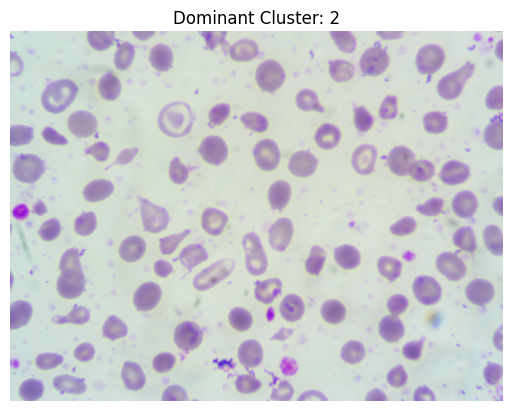

In [ ]:
# Step 8 - Load saved models and test
# ========================
loaded_cnn = tf.keras.models.load_model(os.path.join(SAVE_DIR, "cnn_feature_extractor.keras"))
with open(os.path.join(SAVE_DIR, "pca.pkl"), "rb") as f:
    loaded_pca = pickle.load(f)
with open(os.path.join(SAVE_DIR, "kmeans.pkl"), "rb") as f:
    loaded_kmeans = pickle.load(f)

# Example: Predict cluster of a new RBC image
predict_new_image("/content/drive/MyDrive/testprediction/test_image.jpg",
                  loaded_cnn, loaded_pca, loaded_kmeans)